In [1]:
import json
import numpy as np
import pylab as pl

from scipy.interpolate import interp1d
from astropy import cosmology, units as u

import ligo.skymap.plot
import pandas as pd

In [2]:
def get_redshifts(distances, N=10000):
    """
    Compute redshift using the Planck15 cosmology.

    Parameters
    ----------
    distances: float or numpy.ndarray
              distance(s) in Mpc

    N : int, optional
      Number of steps for the computation of the interpolation function

    Example
    -------
    >>> distances = np.linspace(10, 100, 10)
    >>> em_bright.get_redshifts(distances)
    array([0.00225566, 0.00450357, 0.00674384, 0.00897655,
           0.01120181, 0.0134197 , 0.01563032, 0.01783375
           0.02003009, 0.02221941])

    Notes
    -----
    This function accepts HDF5 posterior samples file and computes
    redshift by interpolating the distance-redshift relation.
    """
    function = cosmology.Planck18.luminosity_distance
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    z_min = cosmology.z_at_value(func=function, fval=min_dist*u.Mpc)
    z_max = cosmology.z_at_value(func=function, fval=max_dist*u.Mpc)
    z_steps = np.linspace(z_min - (0.1*z_min), z_max + (0.1*z_min), N)
    lum_dists = cosmology.Planck15.luminosity_distance(z_steps)
    s = interp1d(lum_dists, z_steps)
    redshifts = s(distances)
    return redshifts

In [3]:
path_csv = "/home/licheng.yang/Deepclean_MDC/injection_set/injections_set_mix.csv"
injections = pd.read_csv(path_csv)
injections_20day = injections[:25000]

In [4]:
mass1 = injections_20day['mass1'].tolist()
mass2 = injections_20day['mass2'].tolist()
dec = injections_20day['dec'].tolist()
ra = injections_20day['ra'].tolist()
dist = injections_20day['distance'].tolist()
spin1x = injections_20day['spin1x'].tolist()
spin1y = injections_20day['spin1y'].tolist()
spin1z = injections_20day['spin1z'].tolist()
spin2x = injections_20day['spin2x'].tolist()
spin2y = injections_20day['spin2y'].tolist()
spin2z = injections_20day['spin2z'].tolist()

In [5]:
z = get_redshifts(dist)

In [6]:
ns_mass_max = 2.053556
is_bns = (mass1/(1 + z) <= ns_mass_max)*(mass2/(1 + z) <= ns_mass_max)
is_bbh = (mass1/(1 + z) > ns_mass_max)*(mass2/(1 + z) > ns_mass_max)
is_nsbh = (~is_bns) * (~is_bbh)

is_bns = injections_20day[(injections_20day['mass1']/(1 + z) <= ns_mass_max) & (injections_20day['mass2']/(1 + z) <= ns_mass_max)]
is_bbh = injections_20day[(injections_20day['mass1']/(1 + z) > ns_mass_max) & (injections_20day['mass2']/(1 + z) > ns_mass_max)]
is_nsbh = injections_20day[(injections_20day['mass1']/(1 + z) > ns_mass_max) & (injections_20day['mass2']/(1 + z) <= ns_mass_max)]

## Sky-distribution of injections with $\rho_{\rm optimal} \geq 5.0$

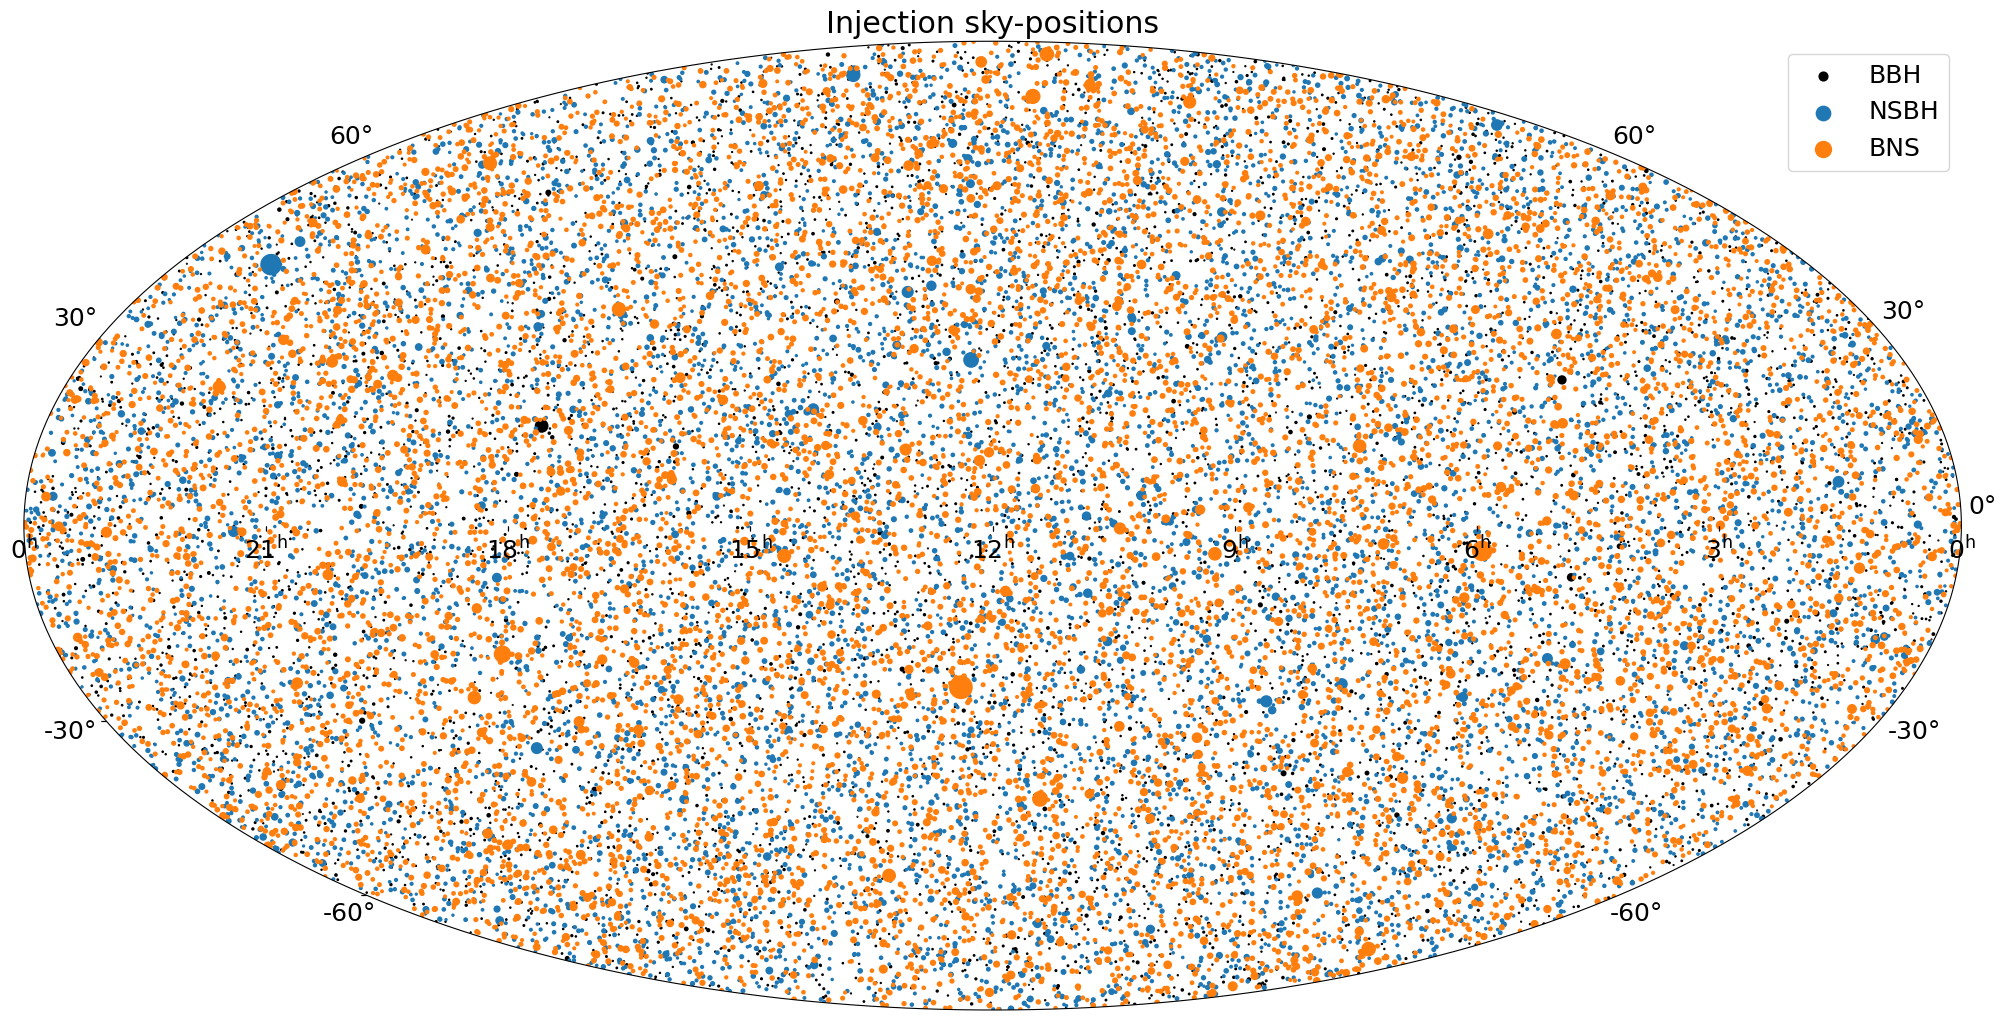

In [7]:
# ra_deg = np.rad2deg(ra)
# dec_deg = np.rad2deg(dec)

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(25,20))
ax = pl.axes(projection='astro hours mollweide')
ax.scatter(np.rad2deg(is_bbh['ra']), np.rad2deg(is_bbh['dec']), marker='.', c='k', s=10000/is_bbh['distance'], 
           transform=ax.get_transform('world'), alpha=1.0, label='BBH')
ax.grid()

ax.scatter(np.rad2deg(is_nsbh['ra']), np.rad2deg(is_nsbh['dec']), marker='.', s=10000/is_nsbh['distance'], 
           transform=ax.get_transform('world'), alpha=1.0, label='NSBH')

ax.scatter(np.rad2deg(is_bns['ra']), np.rad2deg(is_bns['dec']), marker='.', s=10000/is_bns['distance'], 
           transform=ax.get_transform('world'), alpha=1.0, label='BNS')

pl.title('Injection sky-positions')
pl.legend()
ax.grid()
pl.savefig('injection_sky_positions.pdf')

## Source-frame mass distribution of injections with $\rho_{\rm optimal} \geq 5.0$

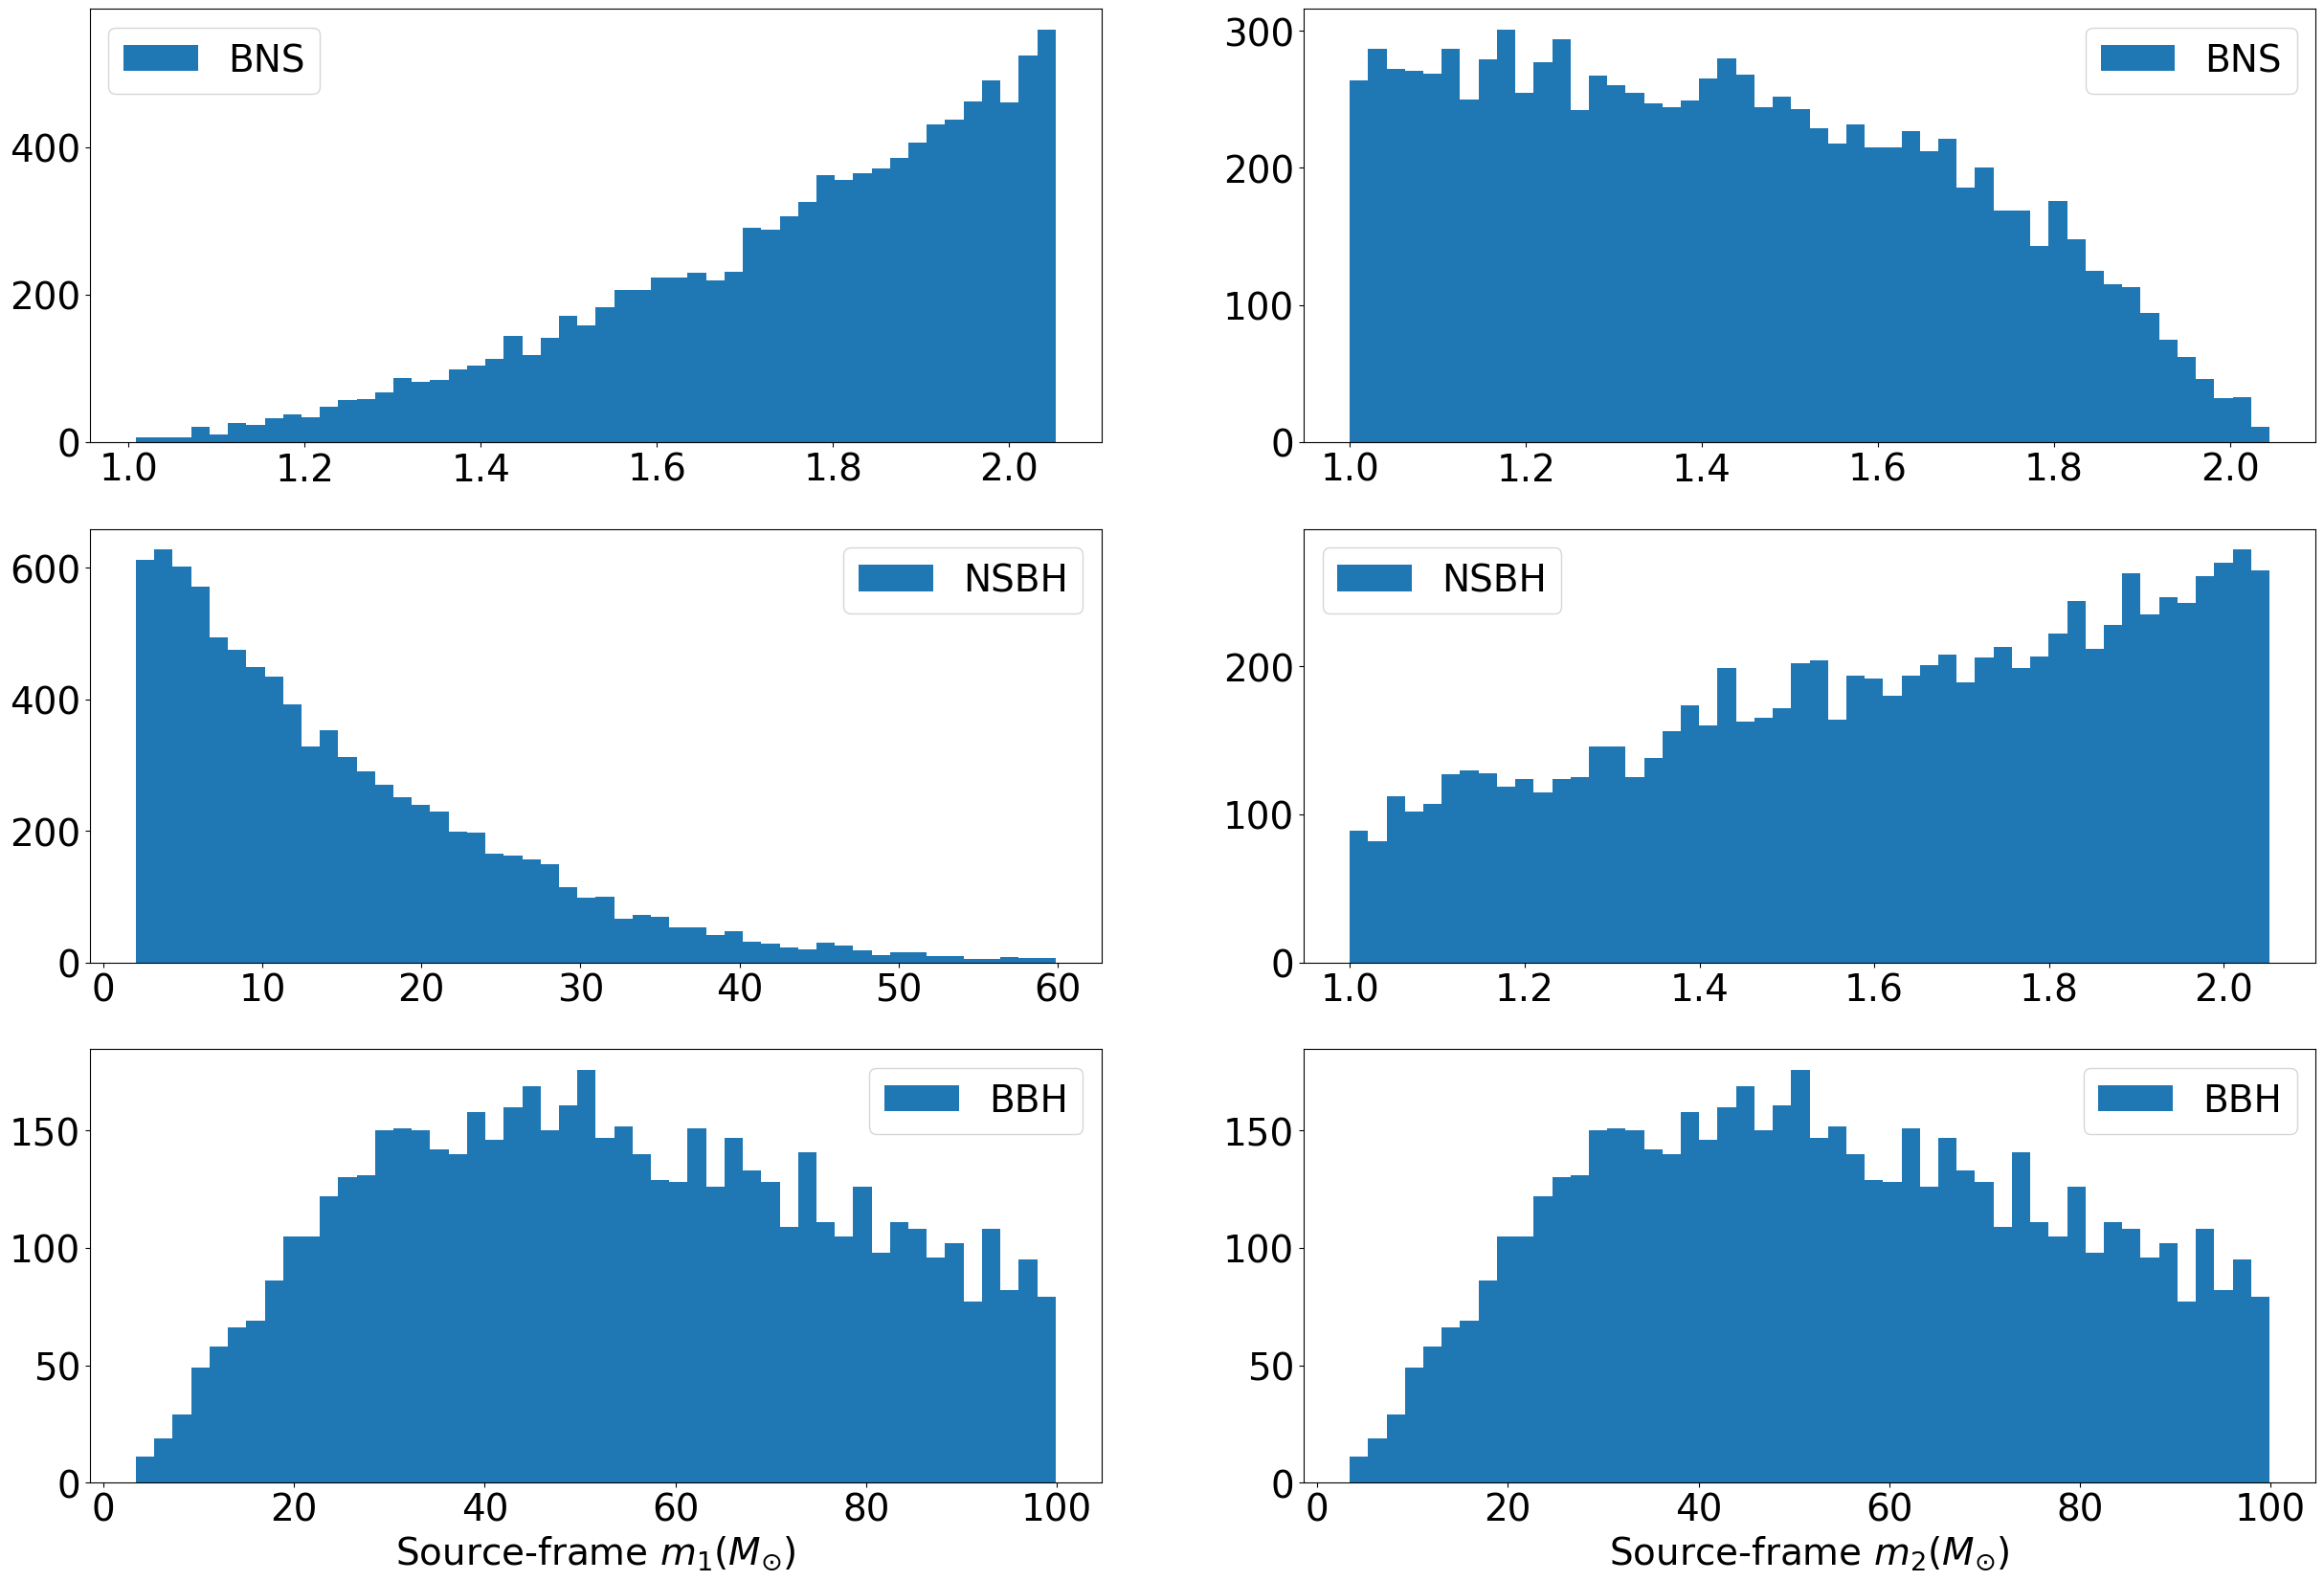

In [8]:
nbins = 50

pl.rcParams.update({'font.size': 28})
pl.figure(figsize=(30,20))
pl.subplot(3,2,1)
pl.hist(is_bns['mass1']/(1 + get_redshifts(is_bns['distance'])), nbins, density=False, label='BNS')
pl.legend()
pl.subplot(3,2,2)
pl.hist(is_bns['mass2']/(1 + get_redshifts(is_bns['distance'])), nbins, density=False, label='BNS')
pl.legend()


pl.subplot(3,2,3)
pl.hist(is_nsbh['mass1']/(1 + get_redshifts(is_nsbh['distance'])), nbins, density=False, label='NSBH')
pl.legend()
pl.subplot(3,2,4)
pl.hist(is_nsbh['mass2']/(1 + get_redshifts(is_nsbh['distance'])), nbins, density=False, label='NSBH')
pl.legend()

pl.subplot(3,2,5)
pl.hist(is_bbh['mass1']/(1 + get_redshifts(is_bbh['distance'])), nbins, density=False, label='BBH')
pl.xlabel('Source-frame $m_1 (M_{\\odot})$')
pl.legend()
pl.subplot(3,2,6)
pl.hist(is_bbh['mass1']/(1 + get_redshifts(is_bbh['distance'])), nbins, density=False, label='BBH')
pl.xlabel('Source-frame $m_2 (M_{\\odot})$')
pl.legend()

pl.savefig("injection_mass_distribution.pdf")
pl.show()

In [9]:
print("Total number of BNS events = {}".format(np.sum(is_bns)))
print("Total number of NSBH events = {}".format(np.sum(is_nsbh)))
print("Total number of BBH events = {}".format(np.sum(is_bbh)))

Total number of BNS events = Unnamed: 0                                              128672965
approximant     IMRPhenomPv2_NRTidalv2IMRPhenomPv2_NRTidalv2IM...
coa_phase                                            32444.410978
dec                                                    -45.574032
distance                                           3860979.046833
f_lower                                                  102880.0
f_ref                                                    102880.0
inclination                                          16107.851969
lambda1                                             1133807.86261
lambda2                                            5808646.808032
mass1                                                19558.288596
mass2                                                15775.122099
polarization                                         16092.203794
ra                                                   32540.864642
spin1x                                         

## Temporal-distribution of injections with $\rho_{\rm optimal} \geq 4.0$

In [10]:
tc = injections_20day['tc'].tolist()
t_diffs = np.diff(tc)
print("Smallest time difference between adjascent injections = {} s".format(np.min(np.diff(tc))))
print('Median time difference between injections = {}'.format(np.median(t_diffs)))

Smallest time difference between adjascent injections = 39.129098415374756 s
Median time difference between injections = 69.06268548965454


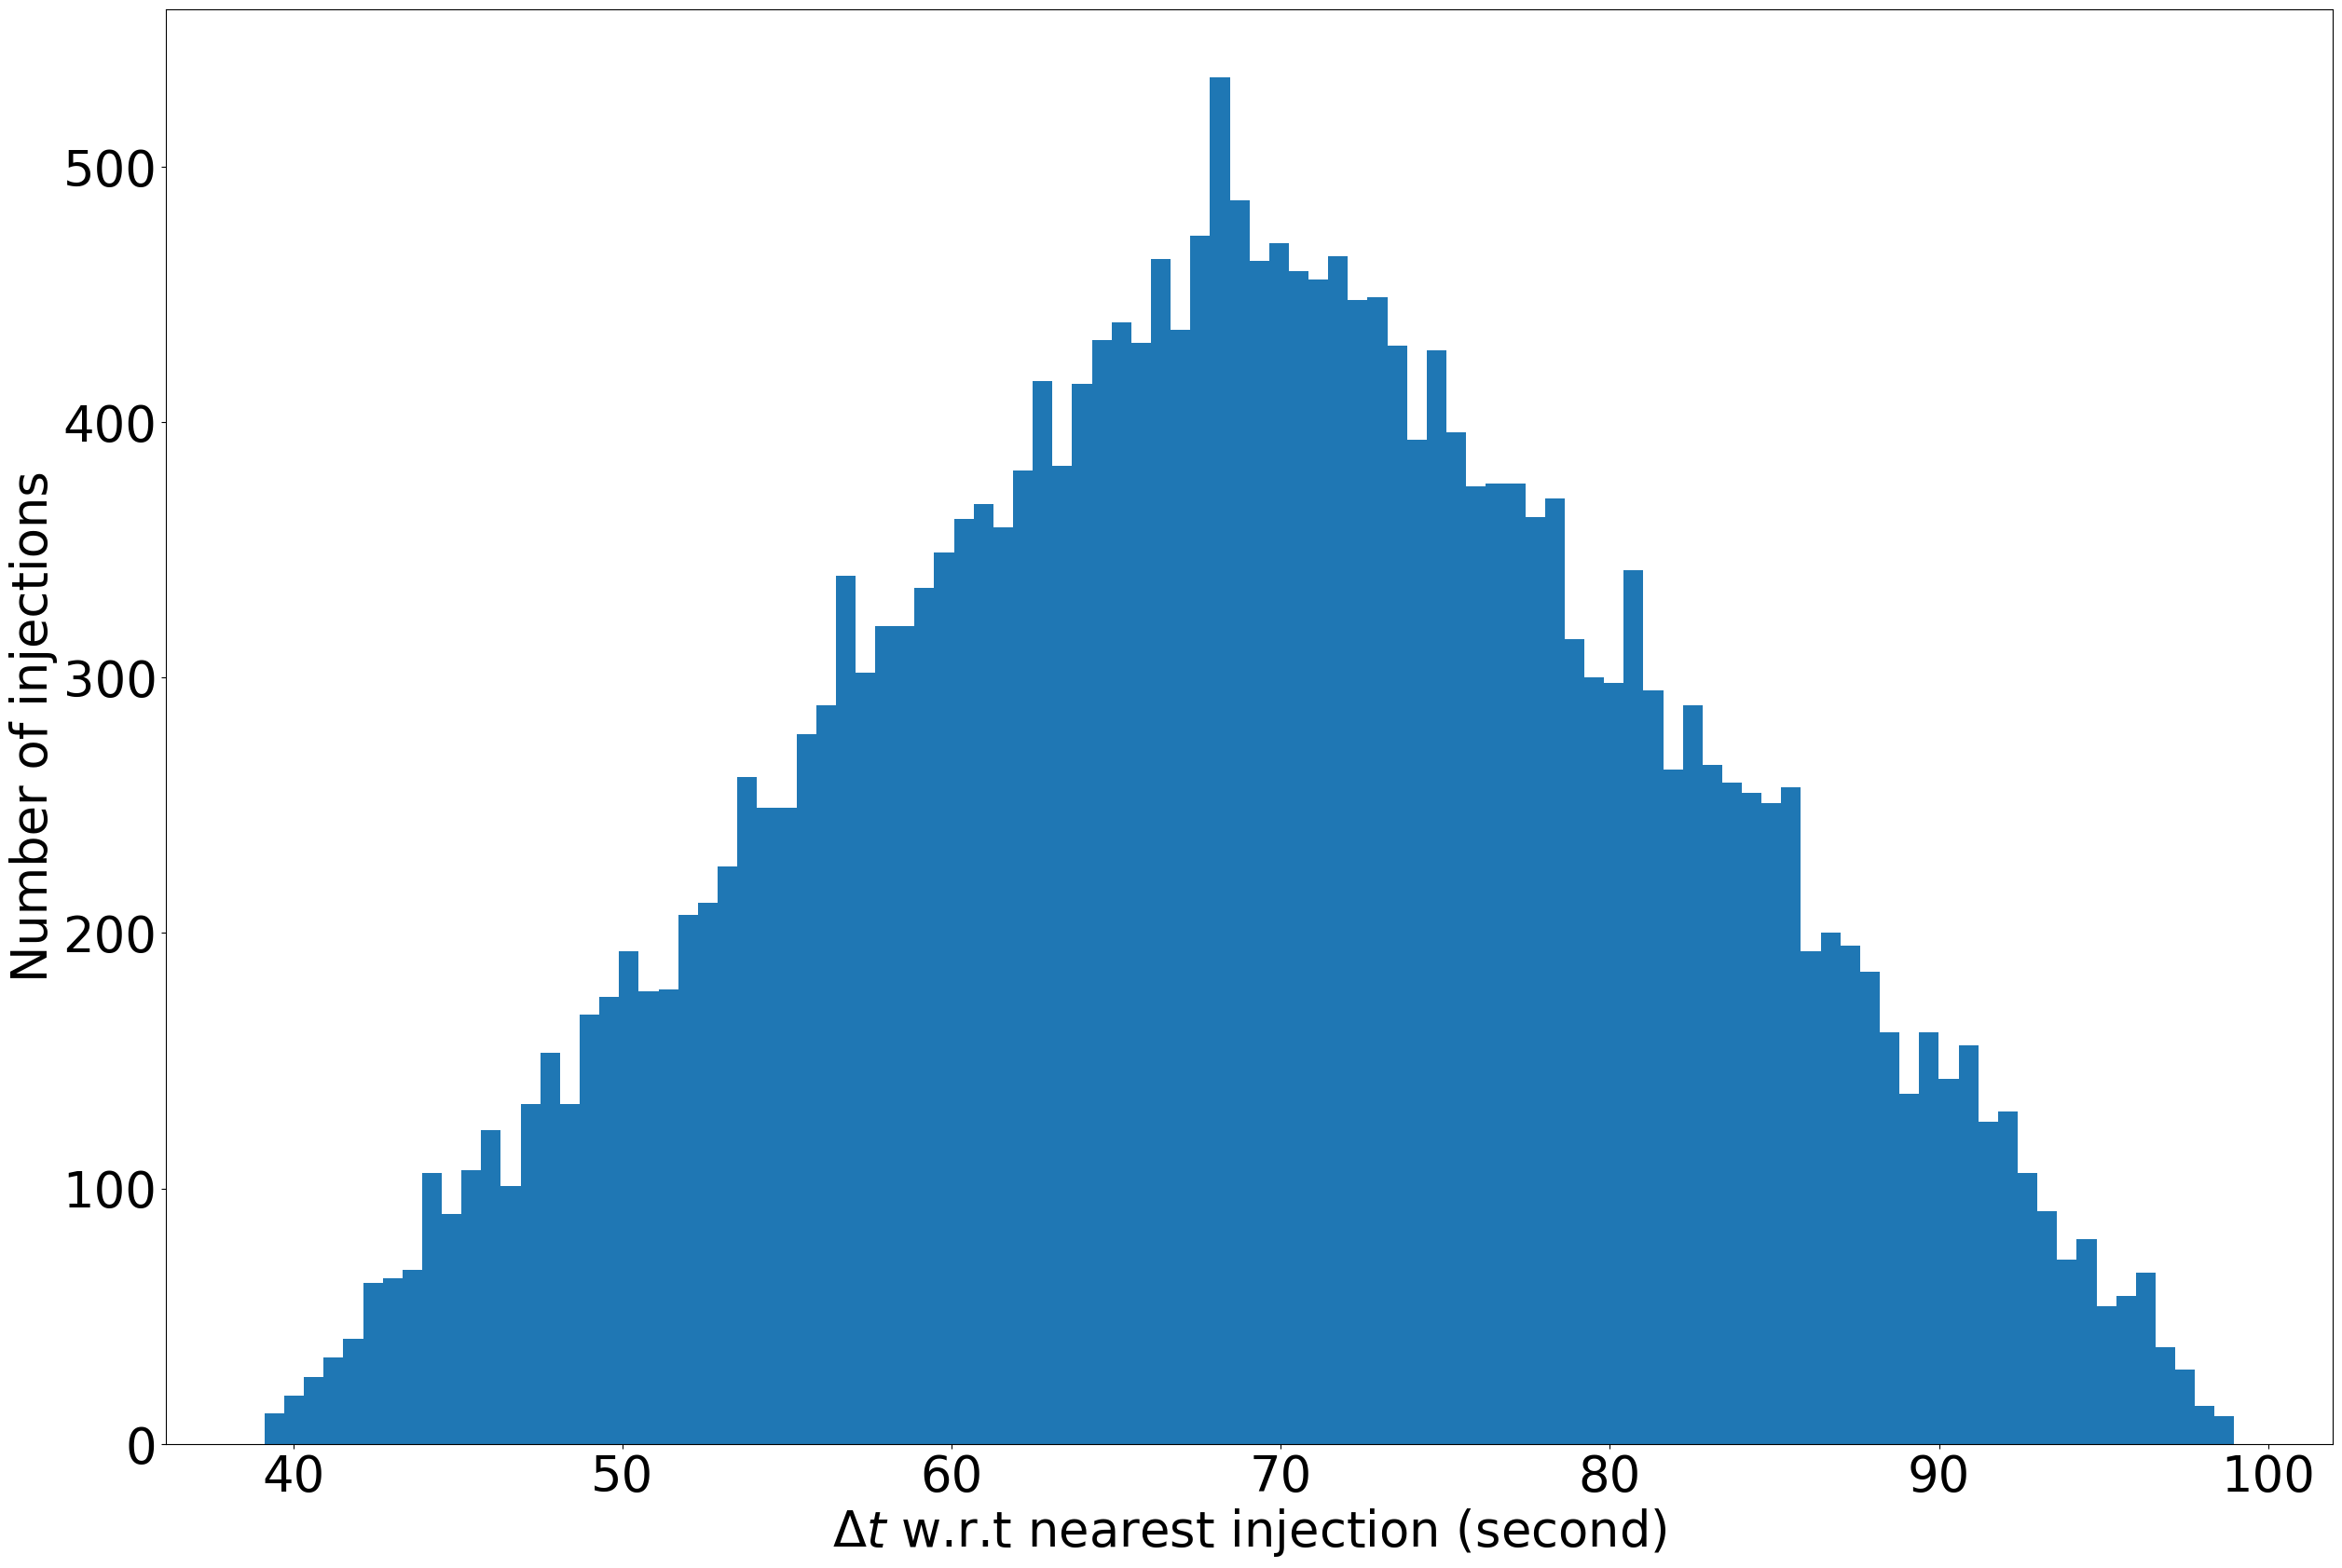

In [11]:
pl.rcParams.update({'font.size': 38})
pl.figure(figsize=(30,20))

pl.hist(t_diffs, 100)
pl.xlabel('$\Delta t$ w.r.t nearest injection (second)')
pl.ylabel('Number of injections')
pl.savefig('injection_temporal_distribution.pdf')
pl.show()